In [35]:
import xarray as xr
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
import numpy as np
from tensorflow.keras.regularizers import l2 # type: ignore
from sklearn.preprocessing import StandardScaler 

In [36]:
ds = xr.open_dataset("data.grib", engine="cfgrib")

print(ds)


<xarray.Dataset> Size: 2MB
Dimensions:     (time: 126, latitude: 27, longitude: 39)
Coordinates:
  * time        (time) datetime64[ns] 1kB 2024-01-01 2024-01-02 ... 2024-11-22
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * latitude    (latitude) float64 216B -1.375 -1.425 -1.475 ... -2.625 -2.675
  * longitude   (longitude) float64 312B 28.98 29.03 29.08 ... 30.78 30.83 30.88
    valid_time  (time) datetime64[ns] 1kB ...
    rootZone    float64 8B ...
Data variables:
    dis24       (time, latitude, longitude) float32 531kB ...
    rowe        (time, latitude, longitude) float32 531kB ...
    swir        (time, latitude, longitude) float32 531kB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history

In [37]:


df = ds.to_dataframe().reset_index()

print(df.head())


        time  latitude  longitude   step  surface valid_time     dis24  \
0 2024-01-01    -1.375     28.975 1 days      0.0 2024-01-02  6.203125   
1 2024-01-01    -1.375     29.025 1 days      0.0 2024-01-02  4.250000   
2 2024-01-01    -1.375     29.075 1 days      0.0 2024-01-02  6.578125   
3 2024-01-01    -1.375     29.125 1 days      0.0 2024-01-02  2.125000   
4 2024-01-01    -1.375     29.175 1 days      0.0 2024-01-02  2.195312   

       rowe  rootZone      swir  
0  5.460327       0.0  0.919109  
1  5.615753       0.0  0.909028  
2  5.696198       0.0  0.894731  
3  5.977570       0.0  0.888318  
4  6.166199       0.0  0.888185  


In [38]:
df['flood'] = (df['dis24'] > 1000).astype(int)

In [39]:

df['rowe_lag1'] = df.groupby(['latitude', 'longitude'])['rowe'].shift(1)


In [40]:
df_combined = df[['rowe', 'swir', 'dis24', 'rowe_lag1', 'flood']]

df_cleaned = df_combined.dropna()

X = df_cleaned[['rowe', 'swir', 'dis24', 'rowe_lag1']]
y = df_cleaned['flood']

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (131625, 4)
y shape: (131625,)


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (105300, 4), y_train shape: (105300,)
X_test shape: (26325, 4), y_test shape: (26325,)


In [42]:
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

In [43]:
y_train_np = y_train_np.reshape(-1, 1)
y_test_np = y_test_np.reshape(-1, 1)


In [44]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

In [45]:
model = Sequential()
input_shape = X_train_scaled.shape[1]
model.add(Dense(32, input_dim=input_shape, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=l2()))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train_np, y_train_np, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_np))


c:\Users\USER\Desktop\Ken\hackathon\flood-alert-system\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9852 - loss: 0.6389 - val_accuracy: 0.9987 - val_loss: 0.0875
Epoch 2/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9988 - loss: 0.0613 - val_accuracy: 0.9987 - val_loss: 0.0151
Epoch 3/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9986 - loss: 0.0075 - val_accuracy: 0.9987 - val_loss: 0.0140
Epoch 4/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9986 - loss: 0.0068 - val_accuracy: 0.9987 - val_loss: 0.0154
Epoch 5/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9987 - loss: 0.0063 - val_accuracy: 0.9987 - val_loss: 0.0149
Epoch 6/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9987 - loss: 0.0062 - val_accuracy: 0.9987 - val_loss: 0.0150
Epoch 7/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9988 - loss: 0.0062 - val_accuracy: 0.9987 - val_loss: 0.0144
Epoch 8/50
3291/3291 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9989 - loss: 0.0061 - 

In [46]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test_np, y_test_np)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


823/823 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9986 - loss: 0.0053
Test Loss: 0.0050
Test Accuracy: 0.9987


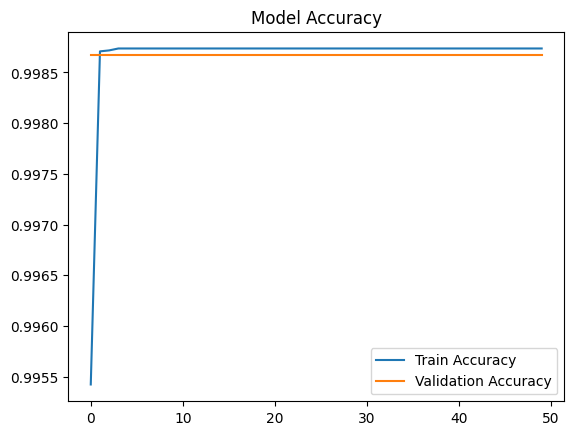

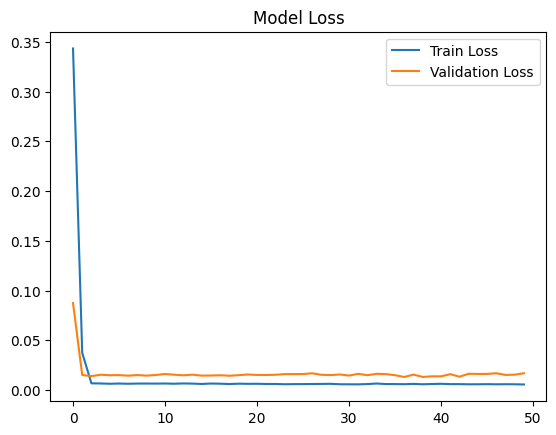

In [47]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [48]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,157 (51.40 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,772 (34.27 KB)

In [49]:
model.save("saved_models/flood_model.h5")

In [50]:
model.save("saved_models/flood_model.keras")

In [53]:
import pickle

with open("saved_models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)